## 1-Imports and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import calendar
from datetime import timedelta


from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
f= open('ultimate_data_challenge.json')
data = json.load(f)

In [3]:
df= pd.DataFrame(data)

## 2- Explore Data


In [4]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Covert date object to datetime and create a new feature to determine if a rider is retained or not based on their last trip date.

In [7]:
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']= pd.to_datetime(df['signup_date'])

In [8]:
df['last_trip_date'].min(), df['last_trip_date'].max() ,df['signup_date'].min(), df['signup_date'].max()

(Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-01-31 00:00:00'))

In [9]:
last_trip_date = df['last_trip_date'].max()- timedelta(days=30)

In [10]:
df['retained']=0
for i in range(df.shape[0]):
    if df.loc[i, 'last_trip_date']>= last_trip_date:
        df.loc[i, 'retained']=1
    else: 
        df.loc[i, 'retained']=0

In [11]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [12]:
retained_pct= df[df['retained']==1].shape[0] / df.shape[0]
retained_pct

0.37608

Therefore, 37.608% of users were retained.

To predict if the users will be active in their 6 month on the system , we need to build a Classification model such as decision tree, Random Forest, Gradient Boosting. The performance metrics will be accuracy, F1 score, and recall/precesion scores using a confusion matrix. 

**Handle missing values**

In [13]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

In [14]:
df['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

Replace missing values for `phone` by "others"

In [15]:
df.phone.fillna('Other', inplace=True)

In [16]:
df.phone.unique()

array(['iPhone', 'Android', 'Other'], dtype=object)

Replace missing values of ratings by the mean values.

In [17]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

**Create dummy variables for categorical features**

In [18]:
df['ultimate_black_user'].unique()

array([ True, False])

In [19]:
df = pd.get_dummies(df, columns= ['ultimate_black_user', 'phone'], drop_first= True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   city                      50000 non-null  object        
 1   trips_in_first_30_days    50000 non-null  int64         
 2   signup_date               50000 non-null  datetime64[ns]
 3   avg_rating_of_driver      50000 non-null  float64       
 4   avg_surge                 50000 non-null  float64       
 5   last_trip_date            50000 non-null  datetime64[ns]
 6   surge_pct                 50000 non-null  float64       
 7   weekday_pct               50000 non-null  float64       
 8   avg_dist                  50000 non-null  float64       
 9   avg_rating_by_driver      50000 non-null  float64       
 10  retained                  50000 non-null  int64         
 11  ultimate_black_user_True  50000 non-null  uint8         
 12  phone_Other       

In [26]:
df['ultimate_black_user_True']= np.int8(df['ultimate_black_user_True'])
df['phone_Other']= np.int8(df['phone_Other'])
df['phone_iPhone']= np.int8(df['phone_iPhone'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   city                      50000 non-null  object        
 1   trips_in_first_30_days    50000 non-null  int64         
 2   signup_date               50000 non-null  datetime64[ns]
 3   avg_rating_of_driver      50000 non-null  float64       
 4   avg_surge                 50000 non-null  float64       
 5   last_trip_date            50000 non-null  datetime64[ns]
 6   surge_pct                 50000 non-null  float64       
 7   weekday_pct               50000 non-null  float64       
 8   avg_dist                  50000 non-null  float64       
 9   avg_rating_by_driver      50000 non-null  float64       
 10  retained                  50000 non-null  int64         
 11  ultimate_black_user_True  50000 non-null  int8          
 12  phone_Other       

In [28]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,ultimate_black_user_True,phone_Other,phone_iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,1,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,1,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,0


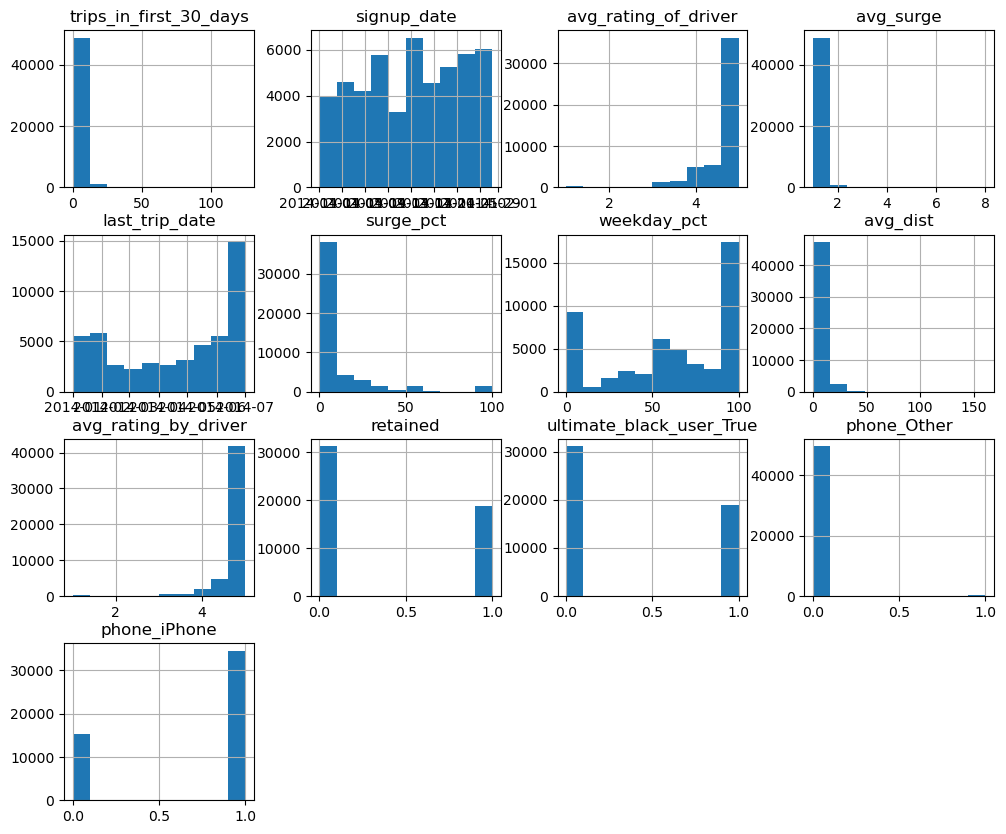

In [29]:
df.hist(figsize=(12,10));

/var/folders/s0/0cfs8q8n5q3dsrtl28251ngw0000gn/T/ipykernel_67997/1072140413.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

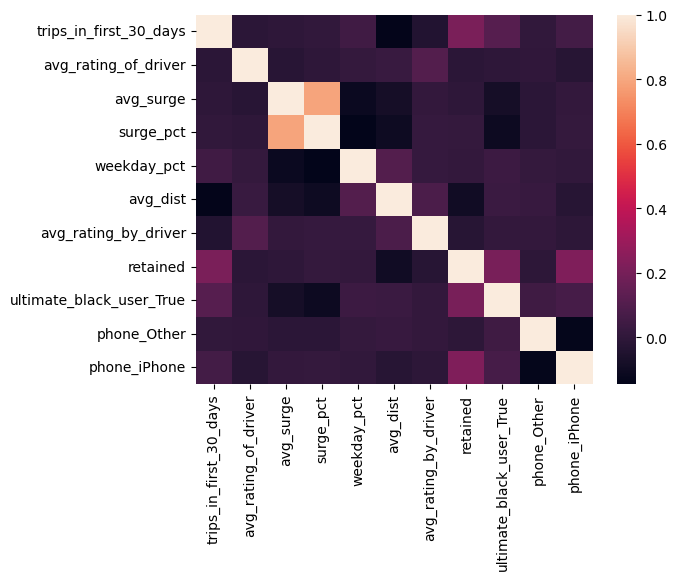

In [30]:
sns.heatmap(df.corr())


From the heatmap we can see that there is not a strong correlation between "retained" feature with rest of the features, however, there are some correlations with `ultimale_black_user_True`, `trips_in_first_30_days`, and `iPhone`.  

## 3- Modeling

**Train/Test Split**

In [31]:
X=df.drop(columns='retained')
y=df.retained

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500, 13), (12500, 13), (37500,), (12500,))

In [34]:
#Save the `city` column
#from the train/test data into names_train and names_test and drop those columns from `X_train` and `X_test`. 

names_list=['city', 'signup_date', 'last_trip_date']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((37500, 10), (12500, 10))

In [35]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

trips_in_first_30_days        int64
avg_rating_of_driver        float64
avg_surge                   float64
surge_pct                   float64
weekday_pct                 float64
avg_dist                    float64
avg_rating_by_driver        float64
ultimate_black_user_True       int8
phone_Other                    int8
phone_iPhone                   int8
dtype: object

### 3.1- Decision Tree

In [36]:
d= [i for i in range(3,20)]
training_accuracy=[]
testing_accuracy=[]

for max_d in d:
    entr_model = tree.DecisionTreeClassifier(criterion="entropy", random_state = 1234, max_depth=max_d, class_weight='balanced')
    entr_model.fit(X_train,y_train)
    y_tr_pred1 = entr_model.predict(X_train) 
    y_te_pred1 = entr_model.predict(X_test)
    tr_accuracy= metrics.recall_score(y_train,y_tr_pred1)
    training_accuracy.append(tr_accuracy)
    te_accuracy= metrics.recall_score(y_test,y_te_pred1)
    testing_accuracy.append(te_accuracy)
    

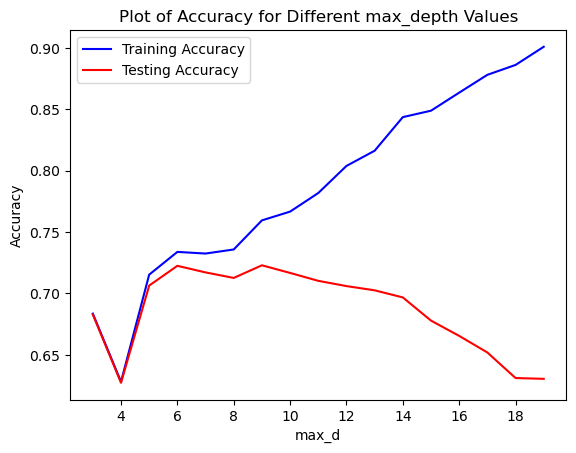

In [37]:
plt.plot(d, training_accuracy, color='blue', label='Training Accuracy')
plt.plot(d, testing_accuracy, color='red', label='Testing Accuracy')
plt.legend()
plt.xlabel('max_d')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy for Different max_depth Values')
plt.show();

In [38]:
max_d=6
entr_model = tree.DecisionTreeClassifier(criterion="entropy", random_state = 1234, max_depth=max_d, class_weight='balanced')
entr_model.fit(X_train,y_train)
y_pred1 = entr_model.predict(X_train) 
y_pred1 = pd.Series(y_pred1) 

# model evaluation 
print("Model: Entropy model, max_depth= {}".format(max_d))
print("Accuracy:", metrics.accuracy_score(y_train,y_pred1))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_train,y_pred1))
print('Precision score:' , metrics.precision_score(y_train,y_pred1))
print('Recall score:' , metrics.recall_score(y_train,y_pred1))
print('F1 score:' , metrics.f1_score(y_train,y_pred1))


Model: Entropy model, max_depth= 6
Accuracy: 0.7291466666666667
Balanced accuracy: 0.7300590887560298
Precision score: 0.6188204424831535
Recall score: 0.733771743742045
F1 score: 0.6714114716443985


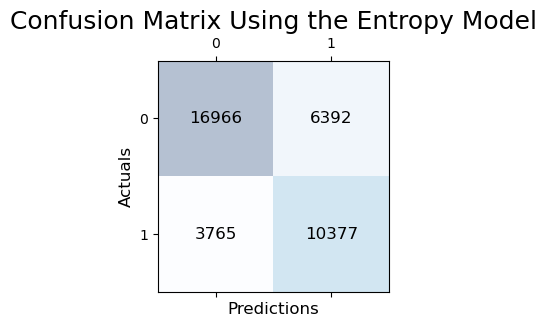

In [39]:
conf_matrix1 = confusion_matrix(y_true=y_train, y_pred=y_pred1)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(conf_matrix1, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix1.shape[0]):
    for j in range(conf_matrix1.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix1[i, j], va='center', ha='center', size=12)

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix Using the Entropy Model', fontsize=18)
plt.show()

### 3.2- Random Forest

In [40]:
RF_Model = RandomForestClassifier(random_state=1234)
RF_Model.fit(X_train, y_train)
y_pred3 = RF_Model.predict(X_train) 
y_pred3 = pd.Series(y_pred3) 

# model evaluation 
print("Model: Random Forest Model")
print("Accuracy:", metrics.accuracy_score(y_train,y_pred3))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_train,y_pred3))
print('Precision score:' , metrics.precision_score(y_train,y_pred3))
print('Recall score:' , metrics.recall_score(y_train,y_pred3))
print('F1 score:' , metrics.f1_score(y_train,y_pred3))

Model: Random Forest Model
Accuracy: 0.9916266666666667
Balanced accuracy: 0.9900840446154692
Precision score: 0.9939277039577082
Recall score: 0.9838070994201669
F1 score: 0.9888415067519544


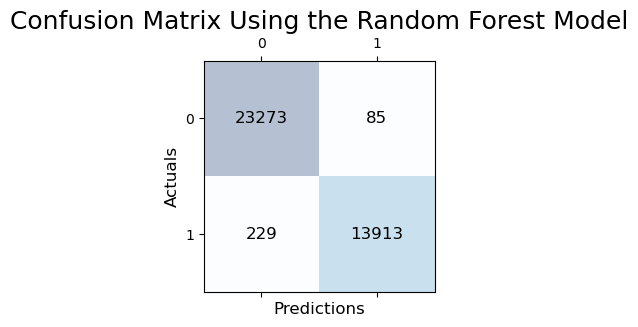

In [41]:
conf_matrix3 = confusion_matrix(y_true=y_train, y_pred=y_pred3)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix3, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix3.shape[0]):
    for j in range(conf_matrix3.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix3[i, j], va='center', ha='center', size=12)

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix Using the Random Forest Model', fontsize=18)
plt.show()

### 3.3- Gradient Boosting

In [42]:
GB_Model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=0)
GB_Model.fit(X_train, y_train)
y_pred4 = GB_Model.predict(X_train) 
y_pred4 = pd.Series(y_pred4) 

# model evaluation 
print("Model: Gradient Boosting Model")
print("Accuracy:", metrics.accuracy_score(y_train,y_pred4))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_train,y_pred4))
print('Precision score:' , metrics.precision_score(y_train,y_pred4))
print('Recall score:' , metrics.recall_score(y_train,y_pred4))
print('F1 score:' , metrics.f1_score(y_train,y_pred4))

Model: Gradient Boosting Model
Accuracy: 0.7852533333333334
Balanced accuracy: 0.7545352807164556
Precision score: 0.7598361355295724
Recall score: 0.629543204638665
F1 score: 0.6885803782048803


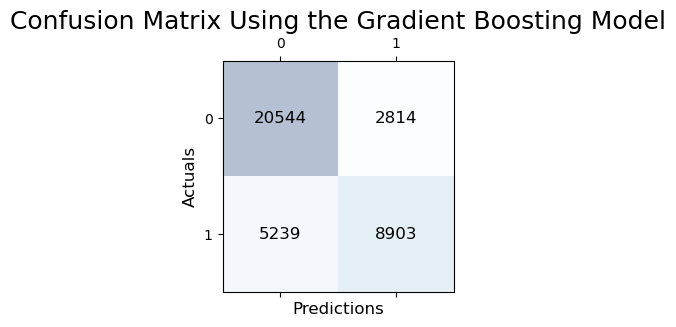

In [43]:
conf_matrix4 = confusion_matrix(y_true=y_train, y_pred=y_pred4)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix4, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix4.shape[0]):
    for j in range(conf_matrix4.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix4[i, j], va='center', ha='center', size=12)

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix Using the Gradient Boosting Model', fontsize=18)
plt.show()

### 3.2- K Nearest Neighbor

In [44]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred8= knn.predict(X_train)
y_pred8 = pd.Series(y_pred8) 

# model evaluation 
print("Model: KNN Classifier Model")
print("Accuracy:", metrics.accuracy_score(y_train,y_pred8))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_train,y_pred8))
print('Precision score:' , metrics.precision_score(y_train,y_pred8))
print('Recall score:' , metrics.recall_score(y_train,y_pred8))
print('F1 score:' , metrics.f1_score(y_train,y_pred8))

Model: KNN Classifier Model
Accuracy: 0.8054666666666667
Balanced accuracy: 0.7845851731817928
Precision score: 0.7645467892743992
Recall score: 0.6996181586762834
F1 score: 0.7306428386810915


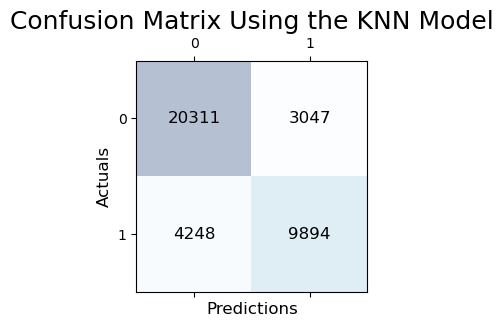

In [45]:
conf_matrix8 = confusion_matrix(y_true=y_train, y_pred=y_pred8)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(conf_matrix8, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix8.shape[0]):
    for j in range(conf_matrix8.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix8[i, j], va='center', ha='center', size=12)

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix Using the KNN Model', fontsize=18)
plt.show()

## 4- Final Model

Several different models were implemented and the final scores were evaluated. The results showed that Random Forest had the highest accuracy (99%), F1 score (99%) and precision (98%) and therefore was the best model.

### 4.1- Model Hyperparameter Tuning

In [46]:
#Perform GridSearchCV to find the best model parameters

param_grid = {'max_depth': np.arange(2, 10), 'criterion':['gini', 'entropy']}

model_cv= GridSearchCV(RF_Model, param_grid, cv=5 , scoring='recall')

In [47]:
model_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='recall')

In [48]:
model_cv.best_params_

{'criterion': 'entropy', 'max_depth': 9}

### 4.2 Predict The Test Data Using The Best Model

In [49]:
y_test_pred = model_cv.best_estimator_.predict(X_test) 

In [50]:
# model evaluation 
print("Model: RandomForest Model Best Estimator")
print("Accuracy:", metrics.accuracy_score(y_test,y_test_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_test_pred))
print('Precision score:' , metrics.precision_score(y_test,y_test_pred))
print('Recall score:' , metrics.recall_score(y_test,y_test_pred))
print('F1 score:' , metrics.f1_score(y_test,y_test_pred))

Model: RandomForest Model Best Estimator
Accuracy: 0.75752
Balanced accuracy: 0.7219902894182046
Precision score: 0.7147748222280748
Recall score: 0.5821535821535821
F1 score: 0.6416834141151436


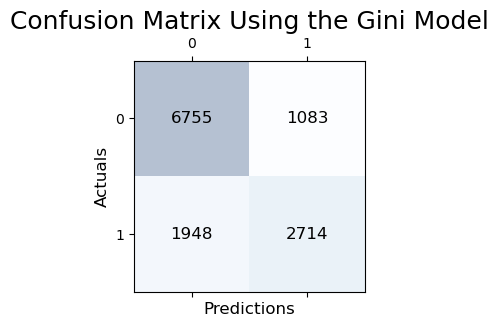

In [51]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size=12)

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix Using the Gini Model', fontsize=18)
plt.show()

>Therefore, our random forest model with criterion= entropy and max_depth=9 could accurately classify 75% of the retained users. The model performance can be improved by providing more information in the users, including more users in the data and try other models to see if they fit data better.

### 4.3- Most important features

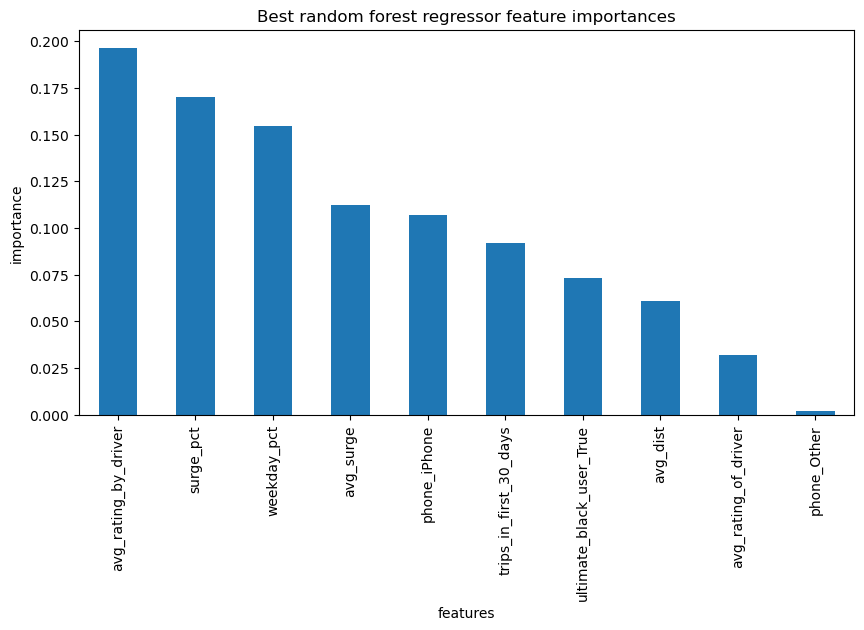

In [52]:
plt.subplots(figsize=(10, 5))
imps = model_cv.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

Seems like the dominant top four features are:
* avg_rating_by_driver
* weekday_pct
* surge_pct
* trips_in_first_30_days